In [195]:
import os
import albumentations
import albumentations.pytorch as AT
import numpy as np
import pandas as pd
import pretrainedmodels
import cv2
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [169]:
train_df = pd.read_csv('./train.csv')
train_df.head()

train_df['species'].unique()

array(['melon_headed_whale', 'humpback_whale', 'false_killer_whale',
       'bottlenose_dolphin', 'beluga', 'minke_whale', 'fin_whale',
       'blue_whale', 'gray_whale', 'southern_right_whale',
       'common_dolphin', 'kiler_whale', 'pilot_whale', 'dusky_dolphin',
       'killer_whale', 'long_finned_pilot_whale', 'sei_whale',
       'spinner_dolphin', 'bottlenose_dolpin', 'cuviers_beaked_whale',
       'spotted_dolphin', 'globis', 'brydes_whale', 'commersons_dolphin',
       'white_sided_dolphin', 'short_finned_pilot_whale',
       'rough_toothed_dolphin', 'pantropic_spotted_dolphin',
       'pygmy_killer_whale', 'frasiers_dolphin'], dtype=object)

There are cases where certain values are dupliates, so you need to fix the duplicate cases.

In [170]:
train_df['individual_id'].nunique()

15587

In [38]:
def duplicate_feature(data, species):
    for duplicate, change in species:
        data['species'] = data['species'].str.replace(duplicate, change)
        
    return data

dup_species = [['bottlenose_dolpin','bottlenose_dolphin'], ['kiler_whale','killer_whale']]
train_df = duplicate_feature(train_df, dup_species)

we can identify some of the species as being dolphine and other as whales,
therefore, we also observe it.

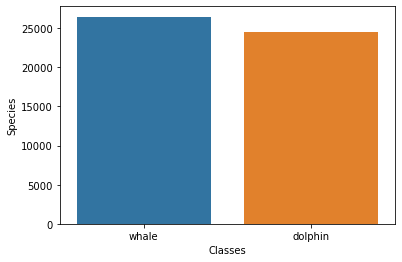

In [51]:
temp = train_df['class'].value_counts()
temp_df = pd.DataFrame({'Classes':temp.index,
                        'Species':temp.values})
sns.barplot(x = 'Classes', y = 'Species', data = temp_df)
plt.show()

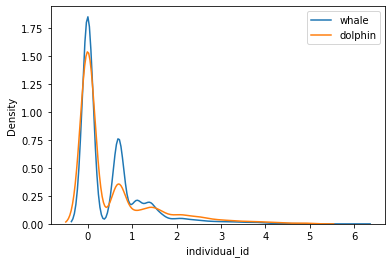

In [65]:
sns.kdeplot(np.log(train_df.loc[train_df['class'] == 'whale']['individual_id'].value_counts()))
sns.kdeplot(np.log(train_df.loc[train_df['class'] == 'dolphin']['individual_id'].value_counts()))
plt.legend(labels = ['whale', 'dolphin'])
plt.show()

In [111]:
print('Top 10 Whale & Dolphin')
train_df['species'].value_counts().head(10)

Top 10 Whale & Dolphin


bottlenose_dolphin    9664
beluga                7443
humpback_whale        7392
blue_whale            4830
false_killer_whale    3326
dusky_dolphin         3139
spinner_dolphin       1700
melon_headed_whale    1689
minke_whale           1608
killer_whale          1493
Name: species, dtype: int64

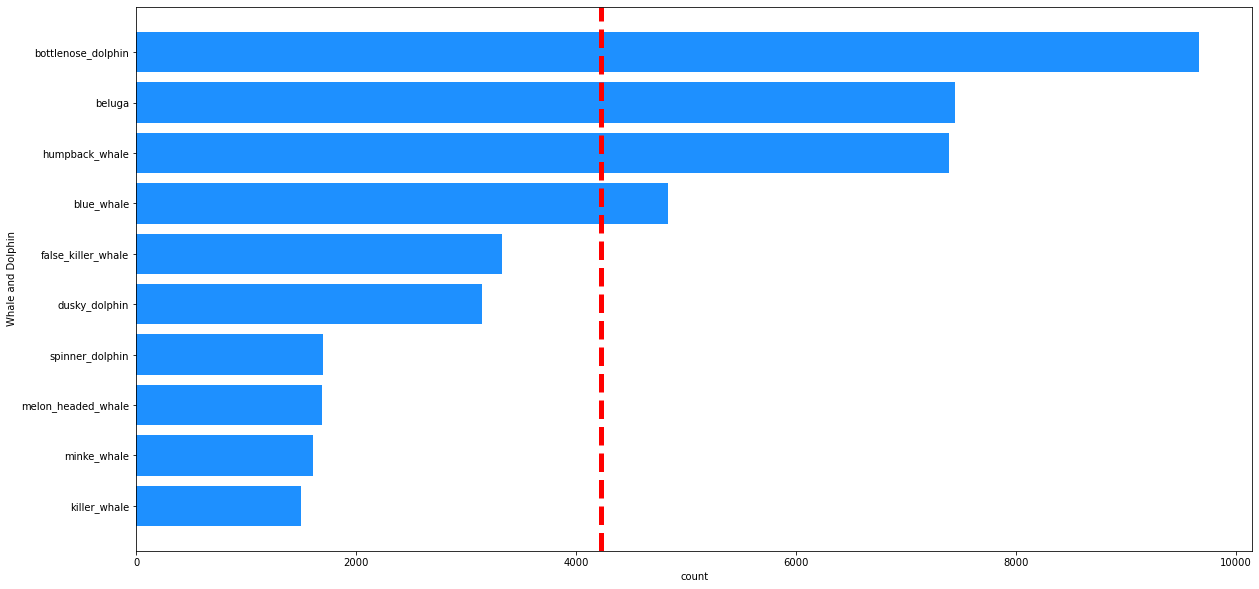

In [164]:
import matplotlib.pyplot as plt
import numpy as np
array = train_df['species'].value_counts().head(10)[::-1]
tmp = array.index.tolist()
count = array.values.tolist()
y = np.arange(10)
plt.figure(figsize = (20, 10))
plt.barh(y, count, color='dodgerblue')
plt.axvline(np.mean(count), ls = '--', color = 'r', linewidth = 5)
plt.yticks(y, tmp)
plt.xlabel('count')
plt.ylabel('Whale and Dolphin')
plt.show()

In [88]:
train_jpg_directory = './train_images'
test_jpg_directory = './test_images'

def getImagesPaths(directory):
    images_names = []
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            images_names.append(fullpath)
    return images_names

train_jpg = getImagesPaths(train_jpg_directory)
test_jpg = getImagesPaths(test_jpg_directory)

def image_directory(df):
    df['image_dir'] = train_jpg_directory + '/'+ df['image']
    
    return df

train_df = image_directory(train_df)
print('Train Images : ', len(train_jpg))
print('Test Images : ', len(test_jpg))

Train Images :  51033
Test Images :  27956


In [77]:
def display_img(images_path, rows, cols, title):
    figure, ax = plt.subplots(nrows= rows, ncols=cols, figsize = (16, 8))
    plt.suptitle(title, fontsize = 20)
    for ind, image_path in enumerate(images_path):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        try:
            ax.ravel()[ind].imshow(image)
            ax.rabel()[ind].set_axis_off()
        except:
            continue
    plt.tight_layout()
    plt.show()

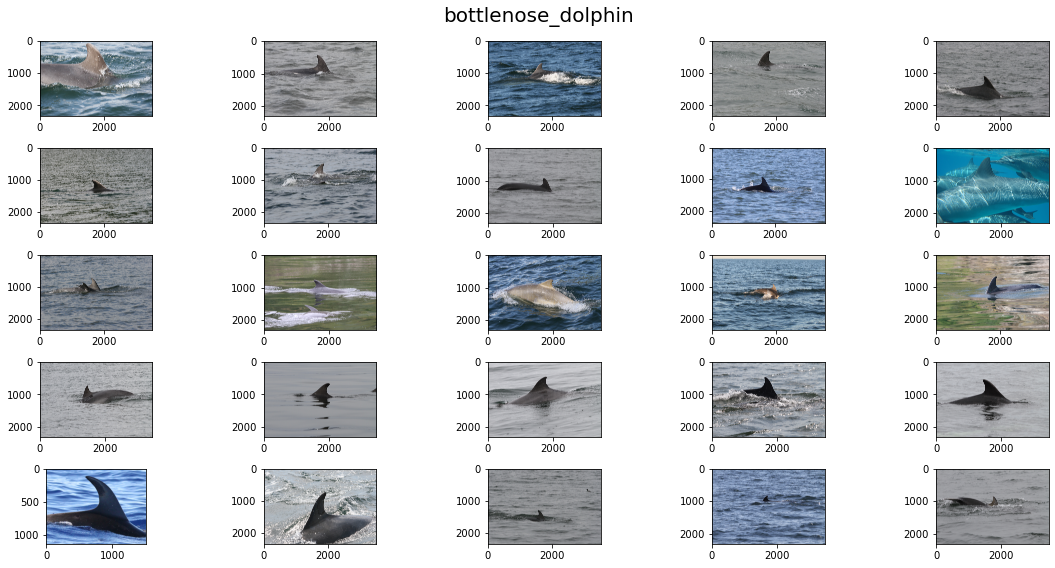

In [99]:
display_img(train_df.loc[train_df['species']=='bottlenose_dolphin']['image_dir'][:25], 5, 5, 'bottlenose_dolphin')

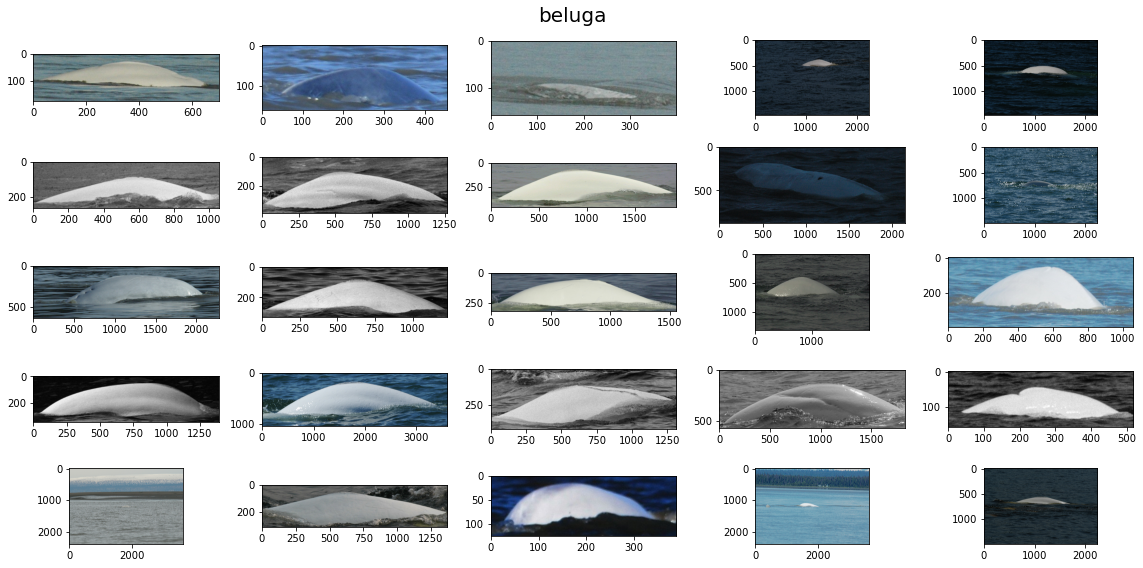

In [100]:
display_img(train_df.loc[train_df['species']=='beluga']['image_dir'][:25], 5, 5, 'beluga')

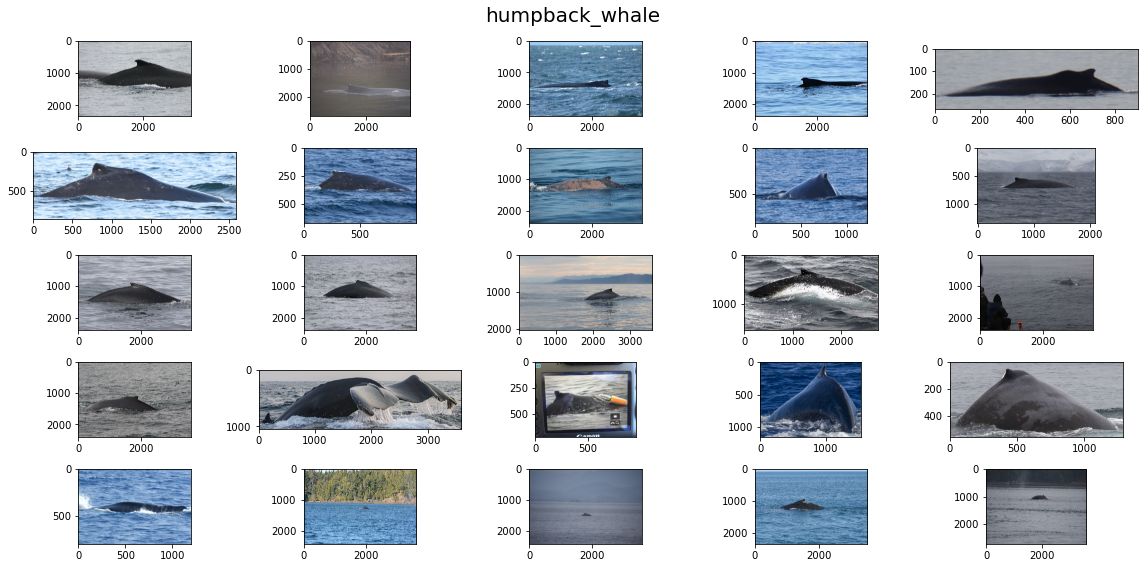

In [101]:
display_img(train_df.loc[train_df['species']=='humpback_whale']['image_dir'][:25], 5, 5, 'humpback_whale')

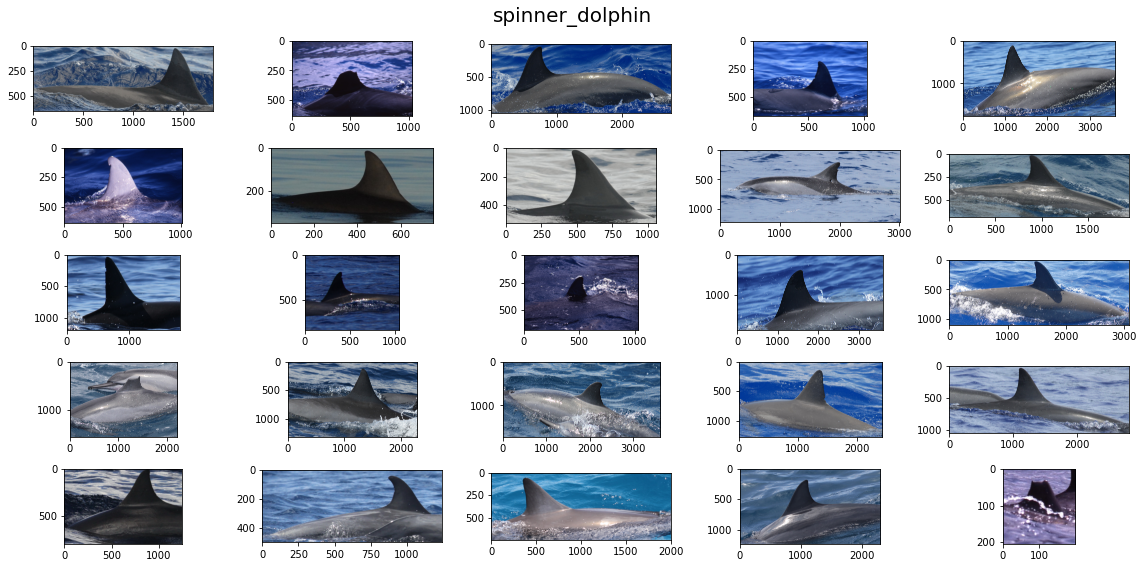

In [102]:
display_img(train_df.loc[train_df['species']=='spinner_dolphin']['image_dir'][:25], 5, 5, 'spinner_dolphin')

In [118]:
def prepare_labeling(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse = False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    y = onehot_encoded
    
    return y, label_encoder

target, label_encoder = prepare_labeling(train_df['individual_id'])
NUM_classes = train_df['individual_id'].nunique()
train_df = train_df.drop('individual_id', axis = 1)

In [172]:
data_transforms = transforms.Compose([
                                      transforms.Resize((100, 100)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])
    ])
data_transforms_test = transforms.Compose([
                                           transforms.Resize((100, 100)),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                 std=[0.229, 0.224, 0.225])
])

In [201]:
class WhaleDataset(Dataset):
    def __init__(self, datafolder, datatype = 'train', df = None, transform = transforms.Compose([transforms.ToTensor()]), y = None):
        self.datafolder = datafolder
        self.datatype = datatype
        self.y = y
        if self.datatype == 'train':
            self.df = df.values
        self.image_file_list = [s for s in os.listdir(datafolder)]
        self.transform = transform
    
    def __len__(self):
        return len(self.image_file_list)
    
    def __getitem__(self, idx):
        if self.datatype == 'train':
            img_name = os.path.join(self.datafolder, self.df[idx][0])
            label = self.y[idx]
    
        elif self.datatype == 'test':
            img_name = os.path.join(self.datafolder, self.image_files_list[idx])
            label = np.zeros((15587,))
        
        image = Image.open(img_name).convert('RGB')
        image = self.transform(image)
        
        if self.datatype == 'train':
            return image, label
        elif self.datatype == 'test':
            return image, label, self.image_file_list[idx]

In [202]:
train_dataset = WhaleDataset(datafolder='./train_images', datatype='train', df=train_df, transform=data_transforms, y=target)
test_set = WhaleDataset(datafolder='./test_images', datatype='test', transform=data_transforms_test)

In [203]:
train_sampler = SubsetRandomSampler(list(range(len(os.listdir('./train_images')))))
valid_sampler = SubsetRandomSampler(list(range(len(os.listdir('./test_images')))))
batch_size = 512
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, num_workers=num_workers)

In [204]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 7, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, 3, padding = 1)
        self.pool2 = nn.AvgPool2d(3, 3)
        
        self.fc1 = nn.Linear(64*4*4*16, 1024)
        self.fc2 = nn.Linear(1024, 15587)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv2_bn(self.conv1(x))))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 4 * 4 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [205]:
model_conv = Net()

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model_conv.parameters(), lr=0.01)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [206]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model_conv.to(device)
n_epochs = 10
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)

    train_loss = []
    exp_lr_scheduler.step()

    for batch_i, data in enumerate(train_loader):
        #print(batch_i)
        data, target = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        output = model_conv(data)
        loss = criterion(output, target.float())
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}')

sub = pd.read_csv('./sample_submission.csv')

model_conv.eval()
for (data, target, name) in test_loader:
    data = data.to(device)
    output = model_conv(data)
    output = output.cpu().detach().numpy()
    for i, (e, n) in enumerate(list(zip(output, name))):
        sub.loc[sub['image'] == n, 'predictions'] = ' '.join(label_encoder.inverse_transform(e.argsort()[-5:][::-1]))
        
sub.to_csv('basic_model.csv', index=False)

Tue Feb 15 20:27:37 2022 Epoch: 1
Epoch 1, train loss: 0.0016
Tue Feb 15 21:11:23 2022 Epoch: 2
Epoch 2, train loss: 0.0007
Tue Feb 15 21:54:30 2022 Epoch: 3
Epoch 3, train loss: 0.0006
Tue Feb 15 22:37:59 2022 Epoch: 4
Epoch 4, train loss: 0.0006
Tue Feb 15 23:20:45 2022 Epoch: 5
Epoch 5, train loss: 0.0006
Wed Feb 16 00:02:06 2022 Epoch: 6
